In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [2]:
df = pd.read_csv('./df10-18.csv')
df.head(2)

,date,category,section,publisher,author,title,content_url,attachment,industry.label,industry.score,industry.name,polarity.label,polarity.score,polarity.name,corp
0,2018-12-27,news,economy,전자신문,NaN,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,NaN,NaN,C21,1.00,의료용 물질 및 의약품 제조업,1.0,0.643,긍정,DeepSearch-CMG제약-news-2018-01-01-2018-12-31-20...
1,2018-12-24,news,economy,한국경제,NaN,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,NaN,NaN,C26,0.59,"전자 부품, 컴퓨터, 영상, 음향 및 통신장비 제조업",1.0,0.667,긍정,DeepSearch-CMG제약-news-2018-01-01-2018-12-31-20...


In [3]:
df = df.iloc[:,[5,11]]

In [4]:
df.head(2)

,title,polarity.label
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0


In [5]:
df_X = df[df['polarity.label'].isna()]
df_O = df[df['polarity.label'].notna()]

In [6]:
mecab = mecab.MeCab()

In [7]:
df_O['tokenized'] = df_O['title'].apply(mecab.morphs)

In [8]:
df_O['polarity.label'].unique()

array([ 1.,  0., -1.])

In [9]:
df_O.head(2)

,title,polarity.label,tokenized
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."


# stop_word

In [10]:
stop_word = pd.read_csv('./stop_word_1.csv')
# stop_word

In [11]:
del_idx = [15,47,50,84,86,91,95,101,107,110,113,114,124,143,150,152,164,166,168,169,178,195,230,255,289,292,295,307,308,311,313
           ,322,326,341,349,350,363,375,381,396,403,424,450,452,468,475,496,509,512,538,541,546,548,550,562,569,576,592,612,624
           ,632,645,649,661,673,699,702,728,741,744,768,769,775,784,787,791,797,809,822,827,831,849,859,864,867,873,886,889,895
           ,902,906,910,929,932,933,936,937,938,945,959,962,964,965,966,979,988,1004,1006,1011,1014,1023,1027,1053,1054,1068,1136
           ,1149,1159,1181,1196,1209,1212,1218,1246,1248,1250,1252,1257,1264,1276]

In [12]:
del_idx1=[]
for idx in del_idx:
    idx_1 = idx-1
    del_idx1.append(idx_1)

In [13]:
del_idx1[:2]

[14, 46]

In [14]:
stop_word[44:47]

,word
44,8
45,1
46,총


In [15]:
stop_word = stop_word.drop(del_idx1,axis=0)

In [16]:
stop_word[12:15]

,word
12,이
13,다
15,년


In [17]:
stop_word.to_csv('./stop_word_2.csv')

In [18]:
df.head(2)

,title,polarity.label
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0


In [19]:
len(df_O)

55345

In [20]:
del_stopword = []
for row in df_O['tokenized']:
    tmp =[]
    for word in row:
        if word not in stop_word:
            tmp.append(word)
    del_stopword.append(tmp)

In [21]:
len(del_stopword)

55345

In [22]:
df_O['del_stopword'] = del_stopword

# Data Load

In [23]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x22bbcd26220>)

In [24]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [25]:
# data.head()

In [26]:
del data['sentence']

In [27]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, -1])
data[:5]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,-1,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [28]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [29]:
data[:2]

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."


In [30]:
df_O[:2]

,title,polarity.label,tokenized,del_stopword
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량...","[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '...","[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."


In [31]:
data = data[['kor_sentence','labels','tokenized']]

In [32]:
data = data.rename(columns={'kor_sentence':'title','labels':'polarity.label'})

In [33]:
del_stopword = []
for row in data['tokenized']:
    tmp =[]
    for word in row:
        if word not in stop_word:
            tmp.append(word)
    del_stopword.append(tmp)

In [34]:
data['del_stopword']=del_stopword

In [35]:
df_O[:2]

,title,polarity.label,tokenized,del_stopword
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량...","[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '...","[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."


In [36]:
data[:2]

,title,polarity.label,tokenized,del_stopword
0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...",0,"[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,0,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회...","[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."


In [37]:
df_O = pd.concat([df_O,data], axis=0)

In [38]:
df_O['polarity.label'].unique()

array([ 1.,  0., -1.])

In [39]:
len(df_O)

60191

In [40]:
df_O.head()

,title,polarity.label,tokenized,del_stopword
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량...","[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '...","[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."
2,"CMG제약(058820) 종목알파고 분석, 외국인/기관 실시간 수급과 추가 매수 확률은?",1.0,"[CMG, 제약, (, 058820, ), 종목, 알파, 고, 분석, ,, 외국인,...","[CMG, 제약, (, 058820, ), 종목, 알파, 고, 분석, ,, 외국인,..."
3,"CMG제약, 전일 대비 약 -4% 하락한 4,515원",0.0,"[CMG, 제약, ,, 전일, 대비, 약, -, 4, %, 하락, 한, 4, ,, ...","[CMG, 제약, ,, 전일, 대비, 약, -, 4, %, 하락, 한, 4, ,, ..."
6,[Hot Stock] CMG제약,1.0,"[[, Hot, Stock, ], CMG, 제약]","[[, Hot, Stock, ], CMG, 제약]"


# 중복제거

In [41]:
duplicate=df_O[df_O.duplicated(subset=['title'])]

In [42]:
len(duplicate)

8303

In [43]:
len(df_O)

60191

In [44]:
# 중복 제거
df_O.drop_duplicates(subset=['title'], inplace=True)

# 라벨 조정
* 부정10배로

In [45]:
df_O["polarity.label"].value_counts()

 1.0    25017
 0.0    21339
-1.0     5532
Name: polarity.label, dtype: int64

In [46]:
print(f'긍정의 비율 = {round(df_O["polarity.label"].value_counts()[0]/len(df_O) * 100,3)}%')
print(f'중립의 비율 = {round(df_O["polarity.label"].value_counts()[1]/len(df_O) * 100,3)}%')
print(f'부정의 비율 = {round(df_O["polarity.label"].value_counts()[-1]/len(df_O) * 100,3)}%')

긍정의 비율 = 41.125%
중립의 비율 = 48.213%
부정의 비율 = 10.661%


In [47]:
df_neg=df_O[df_O["polarity.label"]==-1]

In [48]:
len(df_O),len(df_neg)

(51888, 5532)

In [49]:
for i in range(3):
    df_O = df_O.append(df_neg)

In [50]:
len(df_O),len(df_neg)

(68484, 5532)

In [51]:
df_O["polarity.label"].value_counts()

 1.0    25017
-1.0    22128
 0.0    21339
Name: polarity.label, dtype: int64

In [52]:
print(f'중립의 비율 = {round(df_O["polarity.label"].value_counts()[0]/len(df_O) * 100,3)}%')
print(f'긍정의 비율 = {round(df_O["polarity.label"].value_counts()[1]/len(df_O) * 100,3)}%')
print(f'부정의 비율 = {round(df_O["polarity.label"].value_counts()[-1]/len(df_O) * 100,3)}%')

중립의 비율 = 31.159%
긍정의 비율 = 36.53%
부정의 비율 = 32.311%


In [60]:
# len(df_O)

In [61]:
df_O["polarity.label"] = df_O["polarity.label"].replace([-1,0,1],[2,0,1])

# 테스트-트레인

In [62]:
X = df_O['del_stopword']
y = df_O['polarity.label']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [64]:
X_train.to_csv('./final_X_train.csv')

In [65]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 31.159%
긍정 = 36.531%
부정 = 32.311%


# tokenize

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[1019, 78, 1, 1078, 14, 19, 94, 1048, 467], [5, 707, 7421, 7422, 5008, 1230, 294, 8, 986, 3326, 1673, 217], [3, 1295, 1143, 1674, 4, 453, 60, 22, 1, 114, 4229, 3027, 473, 27, 86, 224, 16, 115], [5693, 14990, 21, 14991, 21, 2077, 88, 9872, 422, 9873, 532, 17, 881, 79, 295, 1906, 4230, 235, 82, 40, 281, 59, 280, 387, 16, 2], [75, 231, 1224, 459, 112, 353, 882, 311]]
[[141, 320, 762, 1, 1622, 2623, 891, 55, 5137, 1847, 528], [3, 32, 12, 4, 560, 435, 1, 88, 584, 442, 6, 354, 12052, 1249], [54, 998, 95, 283, 232, 6, 77, 882, 239, 9, 1848, 30, 1043, 31, 683, 836], [424, 30, 151, 1, 576, 315, 860, 5, 3442, 5, 10562, 219, 201, 145], [90, 8, 1, 1266, 2294, 666, 714, 136, 359, 65, 409, 42, 252, 64]]


In [68]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

24883


## 패딩

본문의 최대 길이 : 77
본문의 평균 길이 : 15.622574698377353


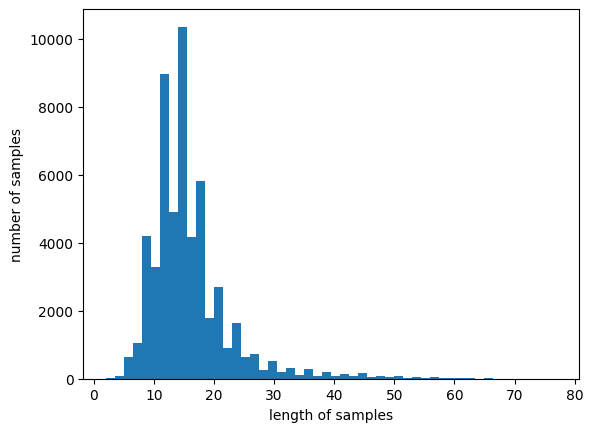

In [69]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [70]:
max_len = 77

In [71]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [72]:
y_train.shape

(54787,)

In [73]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델학습
* 라벨 조정전 테스트 정확도: 0.8776
* 라벨 조정후(부정*3) 테스트 정확도 : 0.9011

In [74]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./NLP/best_model_1018_labelbal.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
1369/1370 [============================>.] - ETA: 0s - loss: 0.3934 - acc: 0.8386
Epoch 1: val_acc improved from -inf to 0.89779, saving model to ./NLP\best_model_1018_labelbal.h5
1370/1370 [==============================] - 48s 34ms/step - loss: 0.3933 - acc: 0.8386 - val_loss: 0.2692 - val_acc: 0.8978
Epoch 2/15
1370/1370 [==============================] - ETA: 0s - loss: 0.1860 - acc: 0.9301
Epoch 2: val_acc improved from 0.89779 to 0.90089, saving model to ./NLP\best_model_1018_labelbal.h5
1370/1370 [==============================] - 49s 36ms/step - loss: 0.1860 - acc: 0.9301 - val_loss: 0.2589 - val_acc: 0.9009
Epoch 3/15
1369/1370 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9544
Epoch 3: val_acc improved from 0.90089 to 0.90108, saving model to ./NLP\best_model_1018_labelbal.h5
1370/1370 [==============================] - 50s 37ms/step - loss: 0.1237 - acc: 0.9544 - val_loss: 0.2834 - val_acc: 0.9011
Epoch 4/15
1369/1370 [========================

In [76]:
loaded_model = load_model('./NLP/best_model_1018_labelbal.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

429/429 [==============================] - 4s 8ms/step - loss: 0.2818 - acc: 0.9011

 테스트 정확도: 0.9011


# 예측

In [77]:
from tensorflow.keras.models import load_model

In [78]:
model=tf.keras.models.load_model(
    './NLP/best_model_1018_labelbal.h5')

In [79]:
df_O.head(2)

,title,polarity.label,tokenized,del_stopword
0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,1.0,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량...","[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,1.0,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '...","[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."


In [80]:
df_X.head(2)

,title,polarity.label
4,간암·뇌전증·치매… 한국 신약 10여종 美 상륙한다,NaN
5,[재송]27일 장 마감 후 주요 종목뉴스,NaN


In [81]:
df_X['tokenized'] = df_X['title'].apply(mecab.morphs)

In [82]:
del_stopword = []
for row in df_X['tokenized']:
    tmp =[]
    for word in row:
        if word not in stop_word:
            tmp.append(word)
    del_stopword.append(tmp)

In [83]:
df_X['del_stopword'] = del_stopword

In [84]:
df_X.head(2)

,title,polarity.label,tokenized,del_stopword
4,간암·뇌전증·치매… 한국 신약 10여종 美 상륙한다,NaN,"[간암, ·, 뇌전증, ·, 치매, …, 한국, 신약, 10, 여종, 美, 상륙, 한다]","[간암, ·, 뇌전증, ·, 치매, …, 한국, 신약, 10, 여종, 美, 상륙, 한다]"
5,[재송]27일 장 마감 후 주요 종목뉴스,NaN,"[[, 재송, ], 27, 일, 장, 마감, 후, 주요, 종목, 뉴스]","[[, 재송, ], 27, 일, 장, 마감, 후, 주요, 종목, 뉴스]"


In [85]:
x=df_X['del_stopword']
y=df_X['polarity.label']

In [86]:
X_encoded = tokenizer.texts_to_sequences(x)

In [87]:
X_encoded = pad_sequences(X_encoded, maxlen=max_len)

In [88]:
pred=model.predict(X_encoded)
pred[:5]

2766/2766 [==============================] - 23s 8ms/step


array([[8.4021926e-02, 9.1573650e-01, 2.4155172e-04],
       [9.9062926e-01, 5.8526048e-03, 3.5180305e-03],
       [5.8136266e-01, 9.0936191e-02, 3.2770115e-01],
       [9.9987245e-01, 1.2330573e-04, 4.2408437e-06],
       [9.3558013e-01, 5.0277159e-02, 1.4142697e-02]], dtype=float32)

In [89]:
len(df_X),len(pred)

(88485, 88485)

In [90]:
label = np.argmax(pred,axis=1)

In [91]:
len(label)

88485

In [92]:
df_X['polarity.label'] = label

In [93]:
df_X[:2]

,title,polarity.label,tokenized,del_stopword
4,간암·뇌전증·치매… 한국 신약 10여종 美 상륙한다,1,"[간암, ·, 뇌전증, ·, 치매, …, 한국, 신약, 10, 여종, 美, 상륙, 한다]","[간암, ·, 뇌전증, ·, 치매, …, 한국, 신약, 10, 여종, 美, 상륙, 한다]"
5,[재송]27일 장 마감 후 주요 종목뉴스,0,"[[, 재송, ], 27, 일, 장, 마감, 후, 주요, 종목, 뉴스]","[[, 재송, ], 27, 일, 장, 마감, 후, 주요, 종목, 뉴스]"


In [94]:
df = pd.concat([df_X,df_O])

In [96]:
df.to_csv('./labelO10-18.csv', index=False)